In [10]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import KFold
from numpy import mean, std
import os
from os import listdir
from numpy import save
from keras.models import load_model
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.image import imread
from shutil import copyfile
from random import seed, random
from AlexNet import AlexNet
from VGG import VGG
from Resnet import Resnet
%matplotlib inline

In [2]:
train_folder = "train/"
database_home = 'dataset_dogs_vs_cats/'

In [3]:
def data_processing():
    photos, labels = list(), list()
    #enumerate file in directory
    for file in listdir(train_folder):
        #determine class
        if file.startswith('cat'):
            output = 1.0
        elif file.startswith('dog'):
            output = 0.0
        #load image
        photo = load_img(train_folder + file, target_size=(224, 224))
        #convert to numpy array
        photo = img_to_array(photo)
        #store
        photos.append(photo)
        labels.append(output)
    #convert to numpy arrays
    photos = np.asarray(photos)
    labels = np.asarray(labels)
    print(photos.shape, labels.shape)
    print(labels)
    #save the reshaped photos
    save('dogs_vs_cats_photos.npy', photos)
    save('dogs_vs_cats_labels.npy', labels)

    subdirs = ['train/', 'test/']
    for subdir in subdirs:
        labeldirs = ['dogs/', 'cats/']
        for labeldir in labeldirs:
            newdir = database_home + subdir + labeldir
            os.makedirs(newdir, exist_ok=True)

In [4]:
def insert_data():
    #seed random number generator
    seed(1)
    #define validation ratio
    val_ratio = 0.25
    #copy training dataset images into subdirectories
    for file in listdir(train_folder):
        src = train_folder + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('cat'):
            dst = database_home + dst_dir + 'cats/' + file
            copyfile(src, dst)
        elif file.startswith('dog'):
            dst = database_home + dst_dir + 'dogs/' + file
            copyfile(src, dst)

In [8]:
def define_model():
    #model = AlexNet()
    #model = VGG()
    model = Resnet()
    opt = Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
#plot diagnostic learning curves
def summarize_diagnostics(histories):
    #plot loss
    plt.subplot(1, 2, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories.history['loss'], color='blue', label='train')
    plt.plot(histories.history['val_loss'], color='orange', label='test')
    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories.history['accuracy'], color='blue', label='train')
    plt.plot(histories.history['val_accuracy'], color='orange', label='test')
    plt.show()
    #save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [20]:
def run_test_harness():
    data_processing()
    insert_data()
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = train_datagen.flow_from_directory(f'{database_home}train/', class_mode='binary', batch_size=64, target_size=(224,224))
    test_it = test_datagen.flow_from_directory(f'{database_home}test/', class_mode='binary', batch_size=64, target_size=(224,224))
    #load model
    filename = 'dogs_vs_cats_model.keras'
    #define model
    model = define_model()
    #fit model
    history = model.fit(train_it, 
                        steps_per_epoch=(train_it.samples // train_it.batch_size), 
                        validation_data=test_it, 
                        validation_steps=(test_it.samples // test_it.batch_size), 
                        epochs=20, verbose=1)
    #evaluate model
    _, acc = model.evaluate(test_it, 
                            steps=(test_it.samples // test_it.batch_size), 
                            verbose=0) 
    print('> %.3f' % (acc * 100.0))
    #learning curves
    summarize_diagnostics(history)
    #save model
    model.save(filename)

(25000, 224, 224, 3) (25000,)
[1. 1. 1. ... 0. 0. 0.]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1543s 5s/step - accuracy: 0.5042 - loss: 0.7680 - val_accuracy: 0.4952 - val_loss: 0.6932
> 49.617


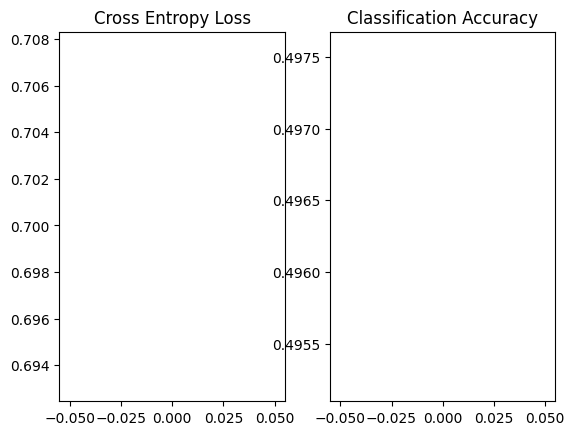

In [21]:
run_test_harness()

In [22]:
model_file = 'dogs_vs_cats_model.keras'
#model_name = AlexNet()
#model_name = VGG()
model_name = Resnet()

In [23]:
def recreate_model():
    return model_name

In [24]:
def load_image(filename):
    img = load_img(filename, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    img = img.astype('float32')
    #center pixel values around 0
    img -= [123.68, 116.779, 103.939]
    return img

In [25]:
def run_example():
    folder_path = 'test1/test1/'
    #load model
    model = load_model(model_file, custom_objects={f'{model_name}': recreate_model()})
    #store predictions
    predictions = []
    #enumerate files in the directory
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            img = load_image(file_path)
            #predict the class
            prediction = model.predict(img)
            result = 1 if prediction >= 0.5 else 0
            predictions.append((file, result))
    return predictions

In [26]:
predictions = run_example()
for filename, result in predictions:
    print(f'Filename: {filename}, Predict: {"Cat" if result == 1 else "Dog"}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━